# Week 7 - Decision Trees and AdaBoost

Alon Hillel-Tuch
ah5647

#### Notes for Grader

I am performing similar pre-processing work as done in the Week 6 assignment. I am putting descriptors where appropriate, but am not going into the same level of explanation for the pre-processing steps as I did for the previous assignment since the dataset and steps are nearly identical. My main focus here is on analyzing the differences between using AdaBoost and not on the decision tree model with either entropy or gini criterion. Further analysis including hyper parameter tuning included at the end. Thanks so much! - Alon

###### Result of Hyper Parameter tuning (extra work)

We also performed some extra work hyper parameter tuning the original decision tree and adaboost parameters. We found an optimal configuration based on the pre-processing we did. 

- decision tree Criterion: Entropy
- min_samples_leaf = 3
- max_depth = 

- adaboost learning-rate = 1.6
- adaboost n_estimators = 1000

We achieved the following progressive improvements in test accuracy:
- initial entropy criterion decision tree (max accuracy from set of max_depth): 96.03
- adaboost applied: 98.43
- hyper parameter tuning: 98.80

Do note there is some overfitting (training accuracy=100), however even with some overfitting, we were able to marginally improve our prediction accuracy on the test set with careful tuning. As a whole, using adaboost on this specific dataset provides for dramatic improvements in accuracy, and at the same time reduces the likelihood of overfitting. 

#### Pre-Processing and imports

In [82]:
# Imports
import numpy as np
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score
from sklearn import tree
from sklearn.model_selection import train_test_split

from sklearn.ensemble import AdaBoostClassifier


import matplotlib.pyplot as plt
import graphviz

import math

In [83]:
# Reading Data (we have it stored as a local file)
df = pd.read_csv('../Week 7/DataSetForPhishingVSBenignUrl.csv')

In [85]:
# Analyzing data set
print("Number of Samples: ", df.shape[0])
print("Number of features: ", df.shape[1])

Number of Samples:  36707
Number of features:  80


In [86]:
#sanity check
df.head()

,Querylength,domain_token_count,path_token_count,avgdomaintokenlen,longdomaintokenlen,avgpathtokenlen,tld,charcompvowels,charcompace,ldl_url,...,SymbolCount_FileName,SymbolCount_Extension,SymbolCount_Afterpath,Entropy_URL,Entropy_Domain,Entropy_DirectoryName,Entropy_Filename,Entropy_Extension,Entropy_Afterpath,URL_Type_obf_Type
0,0,4,5,5.5,14,4.400000,4,8,3,0,...,1,0,-1,0.726298,0.784493,0.894886,0.850608,NaN,-1.0,Defacement
1,0,4,5,5.5,14,6.000000,4,12,4,0,...,0,0,-1,0.688635,0.784493,0.814725,0.859793,0.0,-1.0,Defacement
2,0,4,5,5.5,14,5.800000,4,12,5,0,...,0,0,-1,0.695049,0.784493,0.814725,0.801880,0.0,-1.0,Defacement
3,0,4,12,5.5,14,5.500000,4,32,16,0,...,0,0,-1,0.640130,0.784493,0.814725,0.663210,0.0,-1.0,Defacement
4,0,4,6,5.5,14,7.333334,4,18,11,0,...,0,0,-1,0.681307,0.784493,0.814725,0.804526,0.0,-1.0,Defacement


Similar to previous assignment. We performed an analysis then on dropping NAN entries entirely and concluded it is 'okay' to do for this specific data set. Do note, that this does mean if we are provided data upon which to make a prediction that includes a NAN feature, we would either assign it an agreed upon value (such as 0) or perhaps the mean of all other non-NAN values in that column from either our trained model or perhaps from any input set - a worthwile exploration.  

In [87]:
df2=df.dropna().reset_index(drop=True)
# Analyzing data change
print("Number of Samples: ", df2.shape[0])
print("Number of features: ", df2.shape[1])

# a drop is about 48% of the dataset

Number of Samples:  18982
Number of features:  80


In [88]:
#storing for future graphing purposes if we want to plot general classifications
feature_names = df2.columns[:-1]
class_names = df2.URL_Type_obf_Type.unique()

print(class_names)
#print(feature_names)

['Defacement' 'benign' 'malware' 'phishing' 'spam']


In [89]:
#we are just looking at phishing vs benign as per professor. Disable this cell if you want to run against all classes

#either method below should work
#remove_list= ['Defacement','malware','spam']
#df = df[~df['URL_Type_obf_Type'].isin(remove_list)]
df2.query("URL_Type_obf_Type in ('benign', 'phishing')",inplace=True)
df2.reset_index(drop=True)

#only our class list
class_names = df2.URL_Type_obf_Type.unique()
print(class_names)
#print(feature_names)

['benign' 'phishing']


Storing our dataset features (X) and classification (y)

In [90]:
X = df2.values[:, :-1]
y = df2.values[:,-1]

In [91]:
columns_ = list(df.columns) #storing the column names

pd.DataFrame(X) #sanity check

,0,1,2,3,4,5,6,7,8,9,...,69,70,71,72,73,74,75,76,77,78
0,0,2,12,5.5,8,4.083334,2,15,7,0,...,-1,-1,-1,-1,0.676804,0.860529,-1.0,-1.0,-1.0,-1.0
1,0,3,12,5.0,10,3.583333,3,12,8,2,...,2,1,0,-1,0.715629,0.776796,0.693127,0.738315,1.0,-1.0
2,19,2,10,6.0,9,2.25,2,9,5,0,...,1,5,4,3,0.747202,0.8337,0.655459,0.829535,0.83615,0.823008
3,0,2,10,5.5,9,4.1,2,15,11,0,...,-1,-1,-1,-1,0.732981,0.860529,-1.0,-1.0,-1.0,-1.0
4,0,2,9,2.5,3,4.555555,2,6,3,0,...,5,1,0,-1,0.742606,1.0,0.785719,0.808833,1.0,-1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6718,0,2,5,5.5,8,2.8,2,5,1,0,...,2,1,0,-1,0.734789,0.95351,0.693127,1.0,1.0,-1.0
6719,0,2,5,3.5,5,3.6,2,5,2,0,...,2,1,0,-1,0.793129,0.916667,0.859582,1.0,1.0,-1.0
6720,0,2,4,7.0,12,3.0,2,4,2,0,...,1,1,0,-1,0.797564,0.918863,0.871049,1.0,1.0,-1.0
6721,0,3,5,4.666666,10,2.0,3,3,2,0,...,2,1,0,-1,0.758084,0.90625,0.833333,1.0,1.0,-1.0


##### Under- Sampling  and creating test/train set

In [92]:
#from https://imbalanced-learn.org/stable/references/generated/imblearn.under_sampling.RandomUnderSampler.html

from collections import Counter
from sklearn.datasets import make_classification
from imblearn.under_sampling import RandomUnderSampler 

print('Original dataset shape %s' % Counter(y))

rus = RandomUnderSampler(random_state=42)
X_res, y_res = rus.fit_resample(X, y)
print('Resampled dataset shape %s' % Counter(y_res))

Original dataset shape Counter({'phishing': 4014, 'benign': 2709})
Resampled dataset shape Counter({'benign': 2709, 'phishing': 2709})


In [93]:
test_size_ = 0.2
random_state_ = 100

X_train, X_test, y_train, y_test = train_test_split( X_res, y_res, test_size = test_size_, random_state = random_state_)

### Decision Tree Building and AdaBOOST

We're going to run the model in a loop and store the outcomes. This is based on last weeks assignment, just consolidated for ease of reading

In [109]:
#We are going to store the accuracies for visualization
#format = [depth,accuracy]

######## original set
gini_acc_test = []
ent_acc_test = []

gini_acc_train = []
ent_acc_train = []

gini_abs_diff = []
ent_abs_diff = []

######## abc set

gini_acc_abc_test = []
ent_acc_abc_test = []

gini_acc_abc_train = []
ent_acc_abc_train = []

gini_abs_abc_diff = []
ent_abs_abc_diff = []


##### Gini

Setting up our model with depth_list

In [110]:
depth_list = [1,3,6,9,12,15,18]

for i in range(len(depth_list)):
    
    #Decision Tree
    max_depth_ = depth_list[i]
    min_samples_leaf_ = 5

    tree_gini = DecisionTreeClassifier(criterion = "gini", random_state = 50,
                               max_depth=max_depth_, min_samples_leaf=min_samples_leaf_)
    tree_gini.fit(X_train, y_train)
    y_pred_gini = tree_gini.predict(X_test)
    y_pred_gini_train = tree_gini.predict(X_train)
    
    #create adaboost classifier object
    abc = AdaBoostClassifier(base_estimator=tree_gini)
    #Train Adaboost Classifier
    model = abc.fit(X_train,y_train)
    #predict
    y_pred_test_abc=model.predict(X_test)
    y_pred_train_abc=model.predict(X_train)
    
    #accuracy scores storage
    acc_score_test = accuracy_score(y_test,y_pred_gini)*100
    acc_score_train = accuracy_score(y_train,y_pred_gini_train)*100
    diff = abs(acc_score_test-acc_score_train)
    gini_abs_diff.append([max_depth_,diff])
    gini_acc_test.append([max_depth_,acc_score_test])
    gini_acc_train.append([max_depth_,acc_score_train])
    acc_score_test_abc = accuracy_score(y_test,y_pred_test_abc)*100
    acc_score_train_abc = accuracy_score(y_train,y_pred_train_abc)*100
    diff_abc = abs(acc_score_test_abc-acc_score_train_abc)
    gini_abs_abc_diff.append([max_depth_,diff_abc])
    gini_acc_abc_test.append([max_depth_,acc_score_test_abc])
    gini_acc_abc_train.append([max_depth_,acc_score_train_abc])
                         

We are going to create plots below for analysis

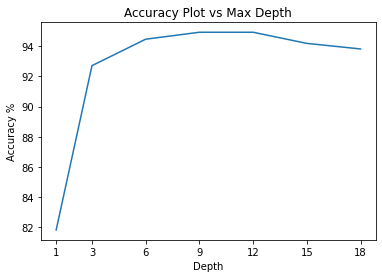

Gini without AdaBoost (test set)
[[1, 81.82656826568265], [3, 92.71217712177122], [6, 94.4649446494465], [9, 94.92619926199262], [12, 94.92619926199262], [15, 94.18819188191881], [18, 93.81918819188192]]


In [111]:
def feature_plot(table):
 
    y_axis = []
    for i in range(len(table)):
        y_axis.append(table[i][1])
    
    x_axis = []
    for i in range(len(table)):
        x_axis.append(table[i][0])
    
    plt.xticks([1,3,6,9,12,15,18])
    plt.plot(x_axis, y_axis) 
    plt.xlabel("Depth") 
    plt.ylabel("Accuracy %") 
    title_val = "Accuracy Plot vs Max Depth"
    plt.title(title_val)
    
   
    plt.show()

feature_plot(gini_acc_test)

#Gini without AdaBoost
print("Gini without AdaBoost (test set)")
print(gini_acc_test)

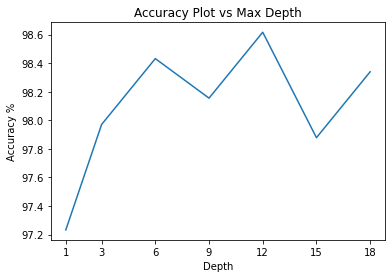

Gini with AdaBoost (test set)
[[1, 97.23247232472325], [3, 97.97047970479706], [6, 98.43173431734317], [9, 98.1549815498155], [12, 98.61623616236163], [15, 97.87822878228782], [18, 98.33948339483395]]


In [112]:
#Gini with AdaBoost
feature_plot(gini_acc_abc_test)
print("Gini with AdaBoost (test set)")
print(gini_acc_abc_test)

###### Analysis of Gini criterion with and without Adaboost 

We can observe in the plots above that adaboost strongly benefits from an increase in depth for the range we set to analyze. While Gini without Adaboost shows a smoother and mostly positively sloped response to an increase in max_depth, when AdaBoost is enabled there are significant spikes in improvement such as depth of 3 and depth of 9. The max_depth is related to how we are pruning our decision trees. Adaboost uses simple one-level decision trees as weak learners added to our ensemble. We iterate through them using the predictions of each model inform the next. The Gini impurity index we are using a more straight forward measurement of the frequency by which a randomly chosen element from our set can be incorrected labelled (against our prediction). Let's look at accuracy of test vs training data for the Gini with to see if we can learn more about the relationship. 

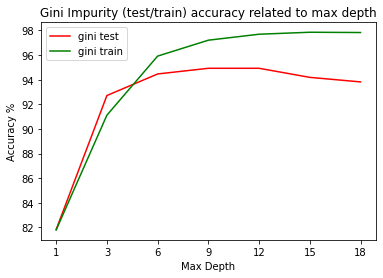

In [113]:
#we are ASSUMING identical cardinality between each set (this is risky for error)
X = []
for i in range(len(gini_acc_test)): 
    X.append(gini_acc_test[i][0])

Y1=[]
for i in range(len(gini_acc_test)): 
    Y1.append(gini_acc_test[i][1])
Y2 = []
for i in range(len(gini_acc_train)): 
    Y2.append(gini_acc_train[i][1])

xi = list(range(len(X)))
plt.xticks(xi, X)
plt.plot(xi, Y1, color='r', label='gini test')
plt.plot(xi, Y2, color='g', label='gini train')


plt.xlabel("Max Depth")
plt.ylabel("Accuracy %")
plt.title("Gini Impurity (test/train) accuracy related to max depth")
  

plt.legend()
  
plt.show()

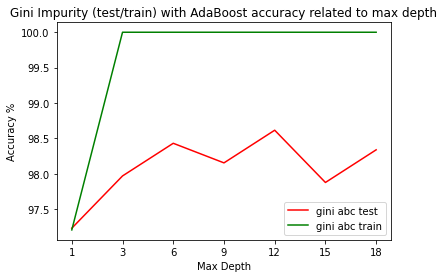

In [114]:
#we are ASSUMING identical cardinality between each set (this is risky for error)
X = []
for i in range(len(gini_acc_abc_test)): 
    X.append(gini_acc_abc_test[i][0])

Y1=[]
for i in range(len(gini_acc_abc_test)): 
    Y1.append(gini_acc_abc_test[i][1])
Y2 = []
for i in range(len(gini_acc_train)): 
    Y2.append(gini_acc_abc_train[i][1])

xi = list(range(len(X)))
plt.xticks(xi, X)
plt.plot(xi, Y1, color='r', label='gini abc test')
plt.plot(xi, Y2, color='g', label='gini abc train')


plt.xlabel("Max Depth")
plt.ylabel("Accuracy %")
plt.title("Gini Impurity (test/train) with AdaBoost accuracy related to max depth")
  

plt.legend()
  
plt.show()

We can see here the dramatic result of adaboost. Causing a noticeably strong fit on the training data as soon as we approach a max_depth of 3. While the adaboost algorithm uses the incorrect classifications as an input for the next model and repeats till we meet a set condition we are still building on top of the original tree classifier here and it's hyper parameters, which includes max_depth. This means that while we notice that our test accuracy has visually observable (by graph) peaks and valleys as we increase max_depth, the specific locations and behavior is an expression of this datasets features and classifications (an obvious statement I know).

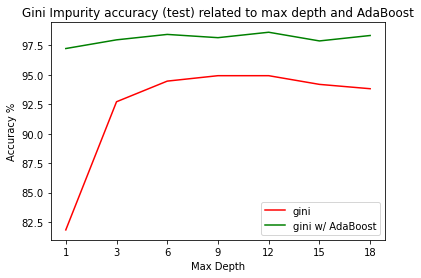

In [115]:
#we are ASSUMING identical cardinality between each set (this is risky for error)
X = []
for i in range(len(gini_acc_test)): 
    X.append(gini_acc_test[i][0])

Y1=[]
for i in range(len(gini_acc_test)): 
    Y1.append(gini_acc_test[i][1])
Y2 = []
for i in range(len(gini_acc_abc_test)): 
    Y2.append(gini_acc_abc_test[i][1])

xi = list(range(len(X)))
plt.xticks(xi, X)
plt.plot(xi, Y1, color='r', label='gini')
plt.plot(xi, Y2, color='g', label='gini w/ AdaBoost')


plt.xlabel("Max Depth")
plt.ylabel("Accuracy %")
plt.title("Gini Impurity accuracy (test) related to max depth and AdaBoost")
  

plt.legend()
  
plt.show()

Looking at the above chart and connecting it with the below chart we can observe something fascinating. **Adaboost results in a reduction of overfitting**.

We can see that after max_depth>=6, the decision with Gini criterion without adaboost starts demonstrating a gradual increase in the absolute value of the difference between test and training accuracy. Note this is the absolute value of the difference, this does not indicate if it's over or underfitting. Either way, adaboost appears to result in a reduction of fitting issues regardless of max_depth when compared, and we can concretely demonstrate this visually. We know when it is overfitted when we see the training accuracy become greater than the test accuracy. 


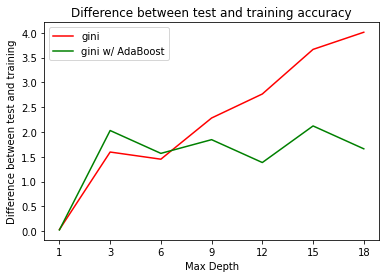

In [116]:
#we are ASSUMING identical cardinality between each set (this is risky for error)
X = []
for i in range(len(gini_abs_diff)): 
    X.append(gini_abs_diff[i][0])

Y1=[]
for i in range(len(gini_abs_diff)): 
    Y1.append(gini_abs_diff[i][1])
Y2 = []
for i in range(len(gini_abs_abc_diff)): 
    Y2.append(gini_abs_abc_diff[i][1])

xi = list(range(len(X)))
plt.xticks(xi, X)

plt.plot(xi, Y1, color='r', label='gini')
plt.plot(xi, Y2, color='g', label='gini w/ AdaBoost')


plt.xlabel("Max Depth")
plt.ylabel("Difference between test and training")
plt.title("Difference between test and training accuracy")
  

plt.legend()
  
plt.show()

##### Entropy

We are going to generate the same charts we used when reviewing Gini criterion in our decision tree.

In [117]:
depth_list = [1,3,6,9,12,15,18]

for i in range(len(depth_list)):
    
    #Decision Tree
    max_depth_ = depth_list[i]
    min_samples_leaf_ = 5

    tree_entropy = DecisionTreeClassifier(criterion = "entropy", random_state = 50,
                               max_depth=max_depth_, min_samples_leaf=min_samples_leaf_)
    tree_entropy.fit(X_train, y_train)
    y_pred_entropy_test = tree_entropy.predict(X_test)
    y_pred_entropy_train = tree_entropy.predict(X_train)
    
    #create adaboost classifier object
    abc = AdaBoostClassifier(base_estimator=tree_entropy)
    #Train Adaboost Classifier
    model = abc.fit(X_train,y_train)
    #predict
    y_pred_test_abc=model.predict(X_test)
    y_pred_train_abc=model.predict(X_train)
    
    #accuracy scores
    acc_score_test = accuracy_score(y_test,y_pred_entropy_test)*100
    acc_score_train = accuracy_score(y_train,y_pred_entropy_train)*100
    diff = abs(acc_score_test-acc_score_train)
    ent_abs_diff.append([max_depth_,diff])
    ent_acc_test.append([max_depth_,acc_score_test])
    ent_acc_train.append([max_depth_,acc_score_train])
    acc_score_test_abc = accuracy_score(y_test,y_pred_test_abc)*100
    acc_score_train_abc = accuracy_score(y_train,y_pred_train_abc)*100
    diff_abc = abs(acc_score_test_abc-acc_score_train_abc)
    ent_abs_abc_diff.append([max_depth_,diff_abc])
    ent_acc_abc_test.append([max_depth_,acc_score_test_abc])
    ent_acc_abc_train.append([max_depth_,acc_score_train_abc])


Entropy without Adaboost


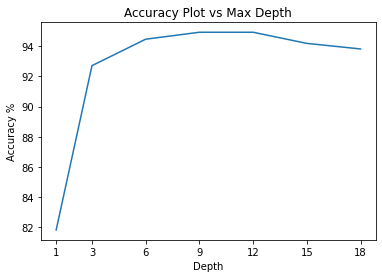

[[1, 81.82656826568265], [3, 90.40590405904058], [6, 95.38745387453874], [9, 95.20295202952029], [12, 95.5719557195572], [15, 95.9409594095941], [18, 96.03321033210332]]

Entropy with Adaboost


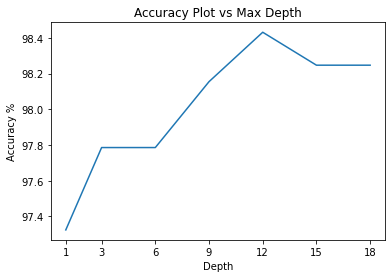

[[1, 97.32472324723247], [3, 97.7859778597786], [6, 97.7859778597786], [9, 98.1549815498155], [12, 98.43173431734317], [15, 98.24723247232473], [18, 98.24723247232473]]


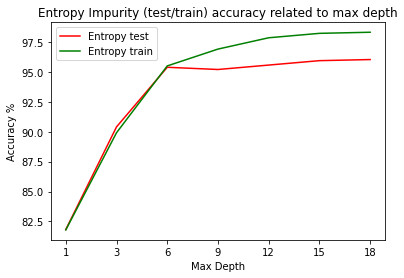

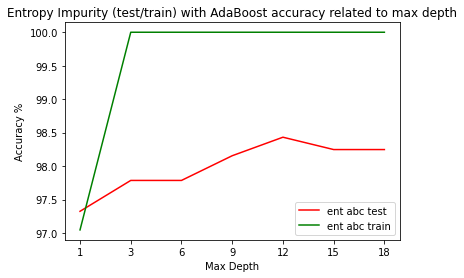

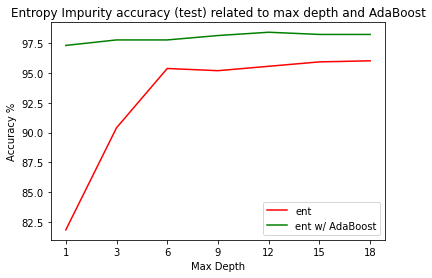

In [118]:
#ent without AdaBoost
print("\nEntropy without Adaboost")
feature_plot(gini_acc_test)
print(ent_acc_test)

#ent with AdaBoost
print("\nEntropy with Adaboost")
feature_plot(ent_acc_abc_test)
print(ent_acc_abc_test)

#we are ASSUMING identical cardinality between each set (this is risky for error)
X = []
for i in range(len(ent_acc_test)): 
    X.append(ent_acc_test[i][0])

Y1=[]
for i in range(len(ent_acc_test)): 
    Y1.append(ent_acc_test[i][1])
Y2 = []
for i in range(len(ent_acc_train)): 
    Y2.append(ent_acc_train[i][1])

xi = list(range(len(X)))
plt.xticks(xi, X)
plt.plot(xi, Y1, color='r', label='Entropy test')
plt.plot(xi, Y2, color='g', label='Entropy train')

plt.xlabel("Max Depth")
plt.ylabel("Accuracy %")
plt.title("Entropy Impurity (test/train) accuracy related to max depth")
  

plt.legend()
  
plt.show()

#we are ASSUMING identical cardinality between each set (this is risky for error)
X = []
for i in range(len(ent_acc_abc_test)): 
    X.append(ent_acc_abc_test[i][0])

Y1=[]
for i in range(len(ent_acc_abc_test)): 
    Y1.append(ent_acc_abc_test[i][1])
Y2 = []
for i in range(len(ent_acc_train)): 
    Y2.append(ent_acc_abc_train[i][1])

xi = list(range(len(X)))
plt.xticks(xi, X)   
plt.plot(xi, Y1, color='r', label='ent abc test')
plt.plot(xi, Y2, color='g', label='ent abc train')

plt.xlabel("Max Depth")
plt.ylabel("Accuracy %")
plt.title("Entropy Impurity (test/train) with AdaBoost accuracy related to max depth")
  

plt.legend()
  
plt.show()

#we are ASSUMING identical cardinality between each set (this is risky for error)
X = []
for i in range(len(ent_acc_test)): 
    X.append(ent_acc_test[i][0])

Y1=[]
for i in range(len(ent_acc_test)): 
    Y1.append(ent_acc_test[i][1])
Y2 = []
for i in range(len(ent_acc_abc_test)): 
    Y2.append(ent_acc_abc_test[i][1])

xi = list(range(len(X)))
plt.xticks(xi, X)
plt.plot(xi, Y1, color='r', label='ent')
plt.plot(xi, Y2, color='g', label='ent w/ AdaBoost')



plt.xlabel("Max Depth")
plt.ylabel("Accuracy %")
plt.title("Entropy Impurity accuracy (test) related to max depth and AdaBoost")
  

plt.legend()
  
plt.show()

When it comes to using the decision tree with entropy criterion we notice a very interesting relationship in the absolute differences between test and training accuracy. Initially with Adaboost enabled there is a substantial difference between the test and training accuracy. It is only after max_depth=6 that the non adaboost version of the decision tree (entropy criterion) starts potentially overfitting (training accuracy becomes noticeably greater than test accuracy). **Even so, enabling AdaBoost for a decision tree with entropy criterion still results in an increase in prediction accuracy**. Below we can see the visualization of the absolute difference, and the cross-over occuring at max_depth=9. **Adaboost is demonstrably reducing the degree of overfitting.**  

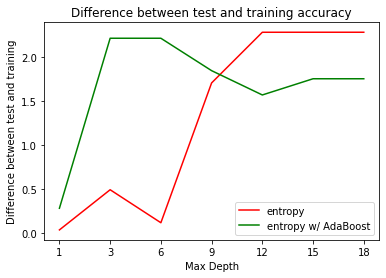

In [120]:
#we are ASSUMING identical cardinality between each set (this is risky for error)
X = []
for i in range(len(ent_abs_diff)): 
    X.append(ent_abs_diff[i][0])

Y1=[]
for i in range(len(ent_abs_diff)): 
    Y1.append(ent_abs_diff[i][1])
Y2 = []
for i in range(len(ent_abs_abc_diff)): 
    Y2.append(ent_abs_abc_diff[i][1])

xi = list(range(len(X)))
plt.xticks(xi, X)
plt.plot(xi, Y1, color='r', label='entropy')
plt.plot(xi, Y2, color='g', label='entropy w/ AdaBoost')



plt.xlabel("Max Depth")
plt.ylabel("Difference between test and training")
plt.title("Difference between test and training accuracy")
  

plt.legend()
  
plt.show()

#### Discussion/ Analysis

Let's first graph both entropy and gini criterion with and without Adaboost all in the same chart

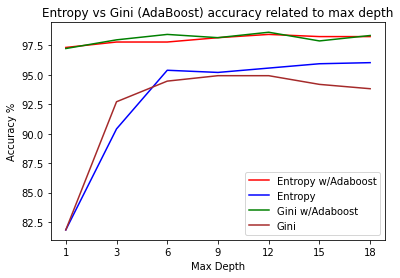

In [121]:
#we are ASSUMING identical cardinality between each set (this is risky for error)
X = []
for i in range(len(ent_acc_abc_test)): 
    X.append(ent_acc_abc_test[i][0])

Y1=[]
for i in range(len(ent_acc_abc_test)): 
    Y1.append(ent_acc_abc_test[i][1])
Y2 = []
for i in range(len(ent_acc_test)): 
    Y2.append(ent_acc_test[i][1])
Y3=[]
for i in range(len(gini_acc_test)): 
    Y3.append(gini_acc_test[i][1])
Y4 = []
for i in range(len(gini_acc_abc_test)): 
    Y4.append(gini_acc_abc_test[i][1])

xi = list(range(len(X)))
plt.plot(xi, Y1, color='red', label='Entropy w/Adaboost')
plt.plot(xi, Y2, color='blue', label='Entropy')
plt.plot(xi, Y4, color='green', label='Gini w/Adaboost')
plt.plot(xi, Y3, color='brown', label='Gini')


plt.xticks(xi, X)
plt.xlabel("Max Depth")
plt.ylabel("Accuracy %")
plt.title("Entropy vs Gini (AdaBoost) accuracy related to max depth")
  

plt.legend()
  
plt.show()

Both the entropy and gini criterion with Adaboost result in a significant increase in the prediction accuracy of the test set. When exclusively looking at prediction accuracy of the test set within in the max depths set defined in the assignment, we identify a test prediction accuracy maximum value at max_depth = 12 of 98.43, for the Decision Tree with Entropy criterion and Adaboost applied. Using that specific max_depth parameter, let's look at the confusion matrix between Entropy with and without Adaboost at max_depth = 12. 

array([[549,   6],
       [ 13, 516]], dtype=int64)

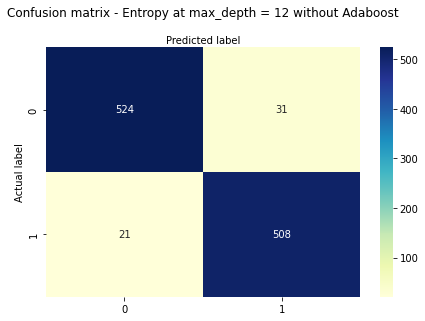

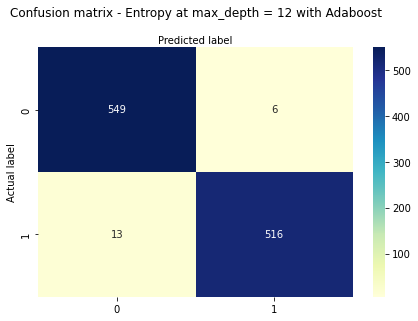

In [129]:
#example diagrams from: https://www.datacamp.com/tutorial/understanding-logistic-regression-python
# import the metrics class
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

    #Decision Tree
max_depth_ = 9
min_samples_leaf_ = 5

tree_ent = DecisionTreeClassifier(criterion = "entropy", random_state = 50,
                               max_depth=max_depth_, min_samples_leaf=min_samples_leaf_)
tree_ent.fit(X_train, y_train)
y_pred_ent_test = tree_ent.predict(X_test)
y_pred_ent_train = tree_ent.predict(X_train)
    
#create adaboost classifier object
abc = AdaBoostClassifier(base_estimator=tree_ent)
#Train Adaboost Classifier
model = abc.fit(X_train,y_train)
#predict
y_pred_test_abc=model.predict(X_test)
y_pred_train_abc=model.predict(X_train)

cnf_matrix_std = metrics.confusion_matrix(y_test, y_pred_ent_test)
cnf_matrix_ada = metrics.confusion_matrix(y_test, y_pred_test_abc)


# create heatmap std
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix_std), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - Entropy at max_depth = 12 without Adaboost', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
cnf_matrix_std

# create heatmap w/adaboost
class_names=[0,1] # name  of classes
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

sns.heatmap(pd.DataFrame(cnf_matrix_ada), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Confusion matrix - Entropy at max_depth = 12 with Adaboost', y=1.1)
plt.ylabel('Actual label')
plt.xlabel('Predicted label')
cnf_matrix_ada

As expected the two confusion matrices track what we already saw in the chart (just a different visualization format). The adaboost truly increases our ability to correctly predict. What is interesting is to look at what was improved. While we are working with a limited dataset, we move from 31 incorrectly predicted as true to 6, which is a 80.6% reduction, and we move from incorrectly predicting false from 21 to 13 which is a 38.1% reduction. I do not believe we can infer from this anything such as 'claiming' adaboost reduces more incorrect true predictions than incorrect false predictions. However, it may imply this observation around the dataset itself and the type of true/false classifications we have. We are potentially observing that with adaboost the individual learners when combined seem to be particularly improved at predicting true for this specific dataset, if we had a lot of noise in our dataset, I do not believe we would have witnessed such improvements. In this case the sequential learning that corrects past models (to inform subsequent) helps reduce bias error which results in use more accurately observing and therefore identifying relevant trends/patterns in the data. As a side note, every time we re-run this analysis we will see slight differences due to the nature of adabosot and the randomness inserted. It won't be significant, but still noticeable. 

###### Extra Analysis on adaboost

We are going to run an analysis to see what the optimal number of trees are for our specific dataset and adaboost

>10 0.971 (0.006)
>50 0.977 (0.006)
>100 0.978 (0.005)
>500 0.979 (0.005)
>1000 0.979 (0.005)
>5000 0.979 (0.004)


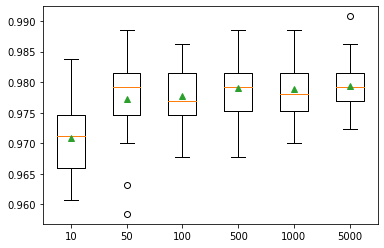

In [25]:
#Source: https://machinelearningmastery.com/adaboost-ensemble-in-python

# explore adaboost ensemble number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot

# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000, 5000]
	for n in n_trees:
		models[str(n)] = AdaBoostClassifier(base_estimator=tree_gini, n_estimators=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


Interesting it appears an n_estimator=500 seems to provide a high accuracy value. A few things to keep in mind, we have 36707 samples. So eventually, if make our tree large enough we start describing almost all 'frequent' outcomes to a degree that we can argue it is highly overfitted, but we may not be able to demonstrate it because we have no data that hasn't been 'described'. Even though there is some test data, we already know from our preprocessing work that this data isn't that noisy, there aren't many outliers. Building out a large and highly detailed tree can 'work' but it's size and complexity can quickly become unrealistic, and I am not convinced that if we used the trained model on new data that we will receive always good predictions. Let's take a look at this as an example setting the max_depth to 5000, the n_estimators for AdaBoost to 5000 and **reduce** min_samples_leaf to 3 from 5, to essentially create a highly specialized tree. This is deliberately excessive to demonstrate a specific outcome. Remember that the min_samples parameter is a cut-off, this is the minimum number of samples that can be grouped together, the lower this number the more tightly we will fit the training data.The larger this number the more likely we may have impurities. Again, this is just a may, if we have a very clean pure set to begin with with simple classifications of features this won't matter too much. 

In [65]:
    #Decision Tree
max_depth_ = 5000
min_samples_leaf_ = 3
n = 5000


tree_ent = DecisionTreeClassifier(criterion = "entropy", random_state = 50,
                               max_depth=max_depth_, min_samples_leaf=min_samples_leaf_)
tree_ent.fit(X_train, y_train)
y_pred_ent_test = tree_ent.predict(X_test)
y_pred_ent_train = tree_ent.predict(X_train)
    
#create adaboost classifier object
abc = AdaBoostClassifier(base_estimator=tree_ent,n_estimators=n)
#Train Adaboost Classifier
model = abc.fit(X_train,y_train)
#predict
y_pred_test_abc=model.predict(X_test)
y_pred_train_abc=model.predict(X_train)

In [66]:
acc_score_test = accuracy_score(y_test,y_pred_test_abc)*100
acc_score_train = accuracy_score(y_train,y_pred_train_abc)*100
print("test accuracy:",acc_score_test)
print("train accuracy:",acc_score_train)

test accuracy: 98.61623616236163
train accuracy: 100.0


Are we overfitted? Yes, purely by the theory of how decision trees work, even with adaboost, by reducing the min_samples_leaf while increasing max_depth we will create a more highly fitted tree, which will increase overfitting. When min_samples_leaf is set to 5 our test accuracy is 98.52, when we set it to 4 we get 98.43, and when set to 3 we get a slightly improved 98.61. Regardless, we simply will reach a maximum accuracy as some samples are truly unique, and when pruning we may remove those outlier outcomes since they're not statistically significant. As mentioned before, if we reduce min_samples, we are creating more opportunities for highly unique groups to be included in the tree) this is at the expense of complexity (time,space), and we will not really see significant improvements in all datasets, or significant increases in tree complexity. 

We can do the same analysis with a gini based decision tree

In [68]:
    #Decision Tree
max_depth_ = 9
min_samples_leaf_ = 3
criterion_ = "gini"

tree = DecisionTreeClassifier(criterion = criterion_, random_state = 50,
                               max_depth=max_depth_, min_samples_leaf=min_samples_leaf_)
tree.fit(X_train, y_train)
y_pred_gini_test = tree.predict(X_test)
y_pred_gini_train = tree.predict(X_train)
acc_score_test = accuracy_score(y_test,y_pred_gini_test)*100
acc_score_train = accuracy_score(y_train,y_pred_gini_train)*100
print("test accuracy:",acc_score_test)
print("train accuracy:",acc_score_train)


test accuracy: 96.03321033210332
train accuracy: 97.85417628057222


>10 0.962 (0.022)
>50 0.970 (0.017)
>100 0.970 (0.016)
>500 0.971 (0.017)
>1000 0.972 (0.014)
>5000 0.973 (0.017)


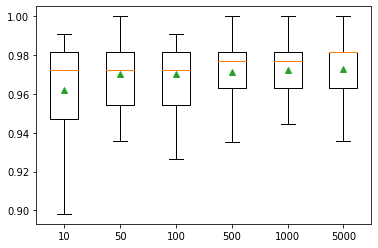

In [98]:
#Source: https://machinelearningmastery.com/adaboost-ensemble-in-python

# explore adaboost ensemble number of trees effect on performance
from numpy import mean
from numpy import std
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot

# get a list of models to evaluate
def get_models():
	models = dict()
	# define number of trees to consider
	n_trees = [10, 50, 100, 500, 1000, 5000]
	for n in n_trees:
		models[str(n)] = AdaBoostClassifier(base_estimator=tree, n_estimators=n)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X, y, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_test, y_test)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.show()


Let's set n to 500 for now, but keep the min_sampels_leaf size to 3 and observe what happens once adaboost is enabled. 

In [76]:
max_depth_ = 500
min_samples_leaf_ = 3
n = 500


tree_ent = DecisionTreeClassifier(criterion = "entropy", random_state = 50,
                               max_depth=max_depth_, min_samples_leaf=min_samples_leaf_)

tree_ent.fit(X_train, y_train)

#create adaboost classifier object
abc = AdaBoostClassifier(base_estimator=tree_ent,n_estimators=n)
#Train Adaboost Classifier
model = abc.fit(X_train,y_train)
#predict
y_pred_test_abc=model.predict(X_test)
y_pred_train_abc=model.predict(X_train)

acc_score_test = accuracy_score(y_test,y_pred_test_abc)*100
acc_score_train = accuracy_score(y_train,y_pred_train_abc)*100
print("test accuracy:",acc_score_test)
print("train accuracy:",acc_score_train)

test accuracy: 98.61623616236163
train accuracy: 100.0


As you can see, no mayor further improvements, even when go unnecessarily small with min_samples_leaf and unnecessarily large with max_depth and setting n = 500. 

###### Evaluate AdaBoost learning rate

Since adaboost makes predictions by calculating the weighted average of the weak classifiers we need to look at how the weighted average is calculated. In this case the weights that make up the weighted average are constructed based on their performance in our learning model and updated using a learning rate. This means, we have a hyper parameter here we can expose to tuning to find an optimal value for this specific (as pre-processed) dataset. 

>0.100 0.970 (0.017)
>0.200 0.965 (0.020)
>0.300 0.966 (0.019)
>0.400 0.968 (0.017)
>0.500 0.969 (0.020)
>0.600 0.968 (0.019)
>0.700 0.971 (0.018)
>0.800 0.970 (0.020)
>0.900 0.970 (0.018)
>1.000 0.971 (0.018)
>1.100 0.971 (0.017)
>1.200 0.970 (0.018)
>1.300 0.970 (0.018)
>1.400 0.970 (0.019)
>1.500 0.970 (0.019)
>1.600 0.972 (0.018)
>1.700 0.972 (0.021)
>1.800 0.967 (0.017)
>1.900 0.967 (0.020)
>2.000 0.969 (0.019)


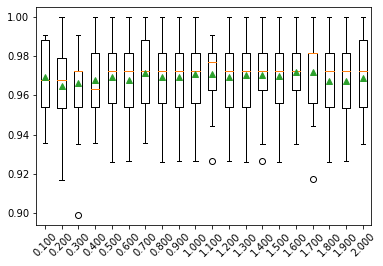

In [92]:
#Modified from Source: https://machinelearningmastery.com/adaboost-ensemble-in-python/

# explore adaboost ensemble learning rate effect on performance
from numpy import mean
from numpy import std
from numpy import arange
from sklearn.datasets import make_classification
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import RepeatedStratifiedKFold
from sklearn.ensemble import AdaBoostClassifier
from matplotlib import pyplot
 
# get a list of models to evaluate
def get_models():
	models = dict()
	# explore learning rates from 0.1 to 2 in 0.1 increments
	for i in arange(0.1, 2.1, 0.1):
		key = '%.3f' % i
		models[key] = AdaBoostClassifier(base_estimator=tree_ent, learning_rate=i)
	return models
 
# evaluate a given model using cross-validation
def evaluate_model(model, X, y):
	# define the evaluation procedure
	cv = RepeatedStratifiedKFold(n_splits=10, n_repeats=3, random_state=1)
	# evaluate the model and collect the results
	scores = cross_val_score(model, X_test, y_test, scoring='accuracy', cv=cv, n_jobs=-1)
	return scores
 

# get the models to evaluate
models = get_models()
# evaluate the models and store results
results, names = list(), list()
for name, model in models.items():
	# evaluate the model
	scores = evaluate_model(model, X_train, y_train)
	# store the results
	results.append(scores)
	names.append(name)
	# summarize the performance along the way
	print('>%s %.3f (%.3f)' % (name, mean(scores), std(scores)))
# plot model performance for comparison
pyplot.boxplot(results, labels=names, showmeans=True)
pyplot.xticks(rotation=45)
pyplot.show()

Again, we do not observe significant changes when modifying the learning rate. We have a range from 0.973-0.978 (0.005). We can see that at learning rate 1.1 and 1.7 there is a tightness around our training accuracy range alongside high performance (so it's leaning towards slightly more accurate on aveage), with 1.6 having a marginally better mean accuracy (0.972 versus 0.971).

In [99]:
max_depth_ = 500
min_samples_leaf_ = 3
n = 500
learning_rate_= 1.6

tree_ent = DecisionTreeClassifier(criterion = "entropy", random_state = 50,
                               max_depth=max_depth_, min_samples_leaf=min_samples_leaf_)

tree_ent.fit(X_train, y_train)

#create adaboost classifier object
abc = AdaBoostClassifier(base_estimator=tree_ent,n_estimators=n,learning_rate = learning_rate_)
#Train Adaboost Classifier
model = abc.fit(X_train,y_train)
#predict
y_pred_test_abc=model.predict(X_test)
y_pred_train_abc=model.predict(X_train)

acc_score_test = accuracy_score(y_test,y_pred_test_abc)*100
acc_score_train = accuracy_score(y_train,y_pred_train_abc)*100
print("test accuracy:",acc_score_test)
print("train accuracy:",acc_score_train)

test accuracy: 98.70848708487084
train accuracy: 100.0


Let's now apply our optimal n_estimators to see if we can increase accuracy any further.

In [100]:
max_depth_ = 1000
min_samples_leaf_ = 3
n = 1000
learning_rate_= 1.6

tree_ent = DecisionTreeClassifier(criterion = "entropy", random_state = 50,
                               max_depth=max_depth_, min_samples_leaf=min_samples_leaf_)

tree_ent.fit(X_train, y_train)

#create adaboost classifier object
abc = AdaBoostClassifier(base_estimator=tree_ent,n_estimators=n,learning_rate = learning_rate_)
#Train Adaboost Classifier
model = abc.fit(X_train,y_train)
#predict
y_pred_test_abc=model.predict(X_test)
y_pred_train_abc=model.predict(X_train)

acc_score_test = accuracy_score(y_test,y_pred_test_abc)*100
acc_score_train = accuracy_score(y_train,y_pred_train_abc)*100
print("test accuracy:",acc_score_test)
print("train accuracy:",acc_score_train)

test accuracy: 98.80073800738008
train accuracy: 100.0


And yes, we 'squeezed' another .1 in accuracy! We have basically reached our limits based on the course material taught so far, and I am looking forward to the next readings and assignments!